In [1]:
# Importing Relevant Packages
from ortools.sat.python import cp_model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import math
import random
import re
import csv
import unicodedata
from collections import defaultdict
from dataclasses import dataclass
from typing import List, Optional
from statistics import stdev
from fpdf import FPDF
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy.optimize import minimize

load C:\Users\andri\anaconda3\Lib\site-packages\ortools\.libs\zlib1.dll...
load C:\Users\andri\anaconda3\Lib\site-packages\ortools\.libs\abseil_dll.dll...
load C:\Users\andri\anaconda3\Lib\site-packages\ortools\.libs\utf8_validity.dll...
load C:\Users\andri\anaconda3\Lib\site-packages\ortools\.libs\re2.dll...
load C:\Users\andri\anaconda3\Lib\site-packages\ortools\.libs\libprotobuf.dll...
load C:\Users\andri\anaconda3\Lib\site-packages\ortools\.libs\highs.dll...
load C:\Users\andri\anaconda3\Lib\site-packages\ortools\.libs\ortools.dll...


In [5]:
@dataclass
class Patient: # Structure for the patients dataset
    id: int # Unique identifier
    name: str # Anonymised patient label
    age: int # Age of patient in years
    gender: str # Gender of patient
    admission_day: int # Day the patient was admitted in the hospital
    release_day: int # Day the patient was released from the hospital
    spec_id: int # ID of the patient's specialism
    spec_days: int # Number of days a patient requires this specialism
    prefered_capacity: int # How many number of beds it is preffered the room to have
    needs: List[int] # ID of features the patient needs
    prefers: List[int] # ID of features the patient prefers

@dataclass
class Room: # Structure for the room dataset
    id: int # Unique room identifier
    room_number: int # Room number in hospital
    department: int # ID of the department the room belongs
    capacity: int # How many beds the room has
    gender: str # Gender the room is designated for
    has: List[int] # Equipment the room has
    spec_ids: List[int] # IDs of the specialisms supported by this room
    penalties: List[int] # Penalties of specialisms

In [7]:
# Build hospital data from CSV
def build_hospital_data():
    # Read room and patient data from CSV
    rooms_df = pd.read_csv("cleaned_rooms1.csv")
    patients_df = pd.read_csv("cleaned_patients1.csv")

    # List for Room objects
    rooms = [
        Room(
            id=i, # Unique ID for each room
            room_number=int(row["RoomNumber"]), # Room number
            department=int(row["DepartmentID"]), # Department ID
            capacity=int(row["Capacity"]), # Room capacity
            gender=row["Gender"], # Gender designation
            has=[ # List for equipment the room has
                int(row["Telemetry"]),
                int(row["Oxygen"]),
                int(row["Nitrogen"]),
                int(row["Television"])
            ],
            spec_ids=[ # List for specialism IDs
                int(row["ReqSpecialism1"]),
                int(row["ReqSpecialism2"]),
                int(row["ReqSpecialism3"])
            ],
            penalties=[ # List for specialism penalties
                int(row["PenaltySpecialism1"]),
                int(row["PenaltySpecialism2"]),
                int(row["PenaltySpecialism3"])
            ]
        )
        for i, row in rooms_df.iterrows() # Iterate through each row
    ]

    # List for Patient objects
    patients = [
        Patient(
            id=i, # Unique patient ID
            name=row["Name"], # Patient label
            age=int(row["Age"]), # Patient age
            gender=row["Gender"], # Patient gender
            admission_day=int(row["AdmissionDay"]), # Admission day
            release_day=int(row["ReleaseDay"]), # Release day
            spec_id=int(row["SpecialismID"]), # Specialism ID
            spec_days=int(row["SpecialismDays"]), # Number of days for specialism
            prefered_capacity=int(row["PreferredRoomCapacity"]), # Preferred room capacity
            needs=[ # List for needed equipment
                int(row["NeedsTelemetry"]),
                int(row["NeedsOxygen"]),
                int(row["NeedsNitrogen"]),
                int(row["NeedsTV"])
            ],
            prefers=[ # List of preferred equipment
                int(row["PrefersTelemetry"]),
                int(row["PrefersOxygen"]),
                int(row["PrefersNitrogen"]),
                int(row["PrefersTV"])
            ]
        )
        for i, row in patients_df.iterrows() # Iterate through each row
    ]

    # Return the lists
    return rooms, patients

In [9]:
# Print the final hospital allocation
class HospitalAllocationPrinter(cp_model.CpSolverSolutionCallback):
    # Initialize the callback
    def __init__(self, seats, patients, rooms):
        super().__init__() 
        self.__seats = seats # Store boolean variables representing assignments
        self.__patients = patients # Store patient objects
        self.__rooms = rooms # Store room objects
        self.__solution_found = False # Flag when solution has been found

    # Callback when an improving solution is found
    def on_solution_callback(self):
        self.__solution_found = True

    # Print the final solution
    def print_final_solution(self, solver):
        print("\nFinal solution:") # Header
        # Iterate through each room
        for room in self.__rooms:
            # Room details
            print(f"\nRoom {room.id} (RoomNum: {room.room_number}, Dept: {room.department}, Capacity: {room.capacity}, Gender: {room.gender}):")
            assigned = False 
            # Iterate through each patient to see if they are assigned to the current room
            for patient in self.__patients:
                if solver.BooleanValue(self.__seats[(room.id, patient.id)]):
                    # Patient details 
                    print(f"  - Patient {patient.name} (Age: {patient.age}, Gender: {patient.gender})")
                    assigned = True 
            # If no assigned patients print "(empty)"
            if not assigned:
                print("  (empty)")

    # Check if a solution has been found
    def solution_found(self):
        return self.__solution_found

In [11]:
# Solution callback for solutions found
class ImprovingSolutionLogger(cp_model.CpSolverSolutionCallback):
    # Initialize the logger
    def __init__(self):
        super().__init__() 
        self.times = [] # Store the time when solution is found
        self.objectives = [] # Store the objective value
        self.start_time = time.time() # Record start time

    # Callback when an improving solution is found
    def on_solution_callback(self):
        elapsed = time.time() - self.start_time # Elapsed time
        current_obj = self.ObjectiveValue() # Objective value of current solution
        self.times.append(elapsed) # Append elapsed time 
        self.objectives.append(current_obj) # Append objective value
        # Print the objective value and time
        print(f"Objective {current_obj} at {elapsed:.2f}s")

In [15]:
# The innitial model was used (from Interim Report) so as to illustrate CP-SAT solving procedure
# Main function for solving the allocation
def solve_hospital_allocation():
    # Build hospital data
    rooms, patients = build_hospital_data()

    # Define planning horizon
    max_day = max(p.admission_day for p in patients)
    previous_assignment = {} # Store previous room assignment
    total_duration = 0 # To calculate total solving time

    all_day_logs = {}  # Store improving solutions

    # Go through each day of the planning horizon
    for day in range(max_day + 1):
        print(f"\n Solving for Day {day}") # Print current day
        # Present patients
        present_patients = [p for p in patients if p.admission_day <= day < p.release_day]
        print(f"Patients present: {len(present_patients)}") 

        if not present_patients: # Skip to the next day if no present patients
            continue

        # CP-SAT Model
        model = cp_model.CpModel()
        # Decision Variable
        seats = { # Boolean variable for each patient-room assignment
            (r.id, p.id): model.NewBoolVar(f"patient_{p.id}_in_room_{r.id}_day{day}")
            for r in rooms for p in present_patients
        }

        # Soft Constraint Violations
        violations_preferred_capacity = [] # List for preferred room capacity violations
        violations_gender = [] # Gender preference
        violations_equipment = [] # Preferred equipment
        equipment_violations = [] # Needed equipment
        move_penalties = [] # Moving penalty
        age_violations = [] # Department age limits
        violations_specialism = [] # Specialism penalties

        # Populate the violation lists based on potential assignments and penalties
        for p in present_patients:
            prev_room = previous_assignment.get(p.id, None) # Patient's previous assignment
            for r in rooms:
                seat = seats[(r.id, p.id)] # Decision variable for this patient-room assignment

                # Check if soft constraint are violated 
                # Capacity Violations
                if r.capacity > p.prefered_capacity:
                    violations_preferred_capacity.append(seat)
                # Gender Violations
                if r.gender in ['F', 'M'] and r.gender != p.gender:
                    violations_gender.append(seat)
                # Equipment Violations
                if any(p.prefers[i] == 1 and r.has[i] == 0 for i in range(4)): 
                    violations_equipment.append(seat)
                if any(p.needs[i] == 1 and r.has[i] == 0 for i in range(4)):
                    equipment_violations.append(seat)
                 # Move Violations
                if prev_room is not None and r.id != prev_room:
                    move_penalties.append(seat)
                # Age Violations
                if (r.department == 1 and p.age < 65) or (r.department == 4 and p.age > 16):
                    age_violations.append(seat)
                # Specialism violations
                if p.spec_id in r.spec_ids:
                    penalty = r.penalties[r.spec_ids.index(p.spec_id)] - 1
                    if penalty > 0: 
                        violations_specialism.extend([seat] * penalty)
                else: 
                    violations_specialism.extend([seat] * 3)

        # Hard Constraints
        # Each patient must be assigned to one room
        for p in present_patients:
            model.Add(sum(seats[(r.id, p.id)] for r in rooms) == 1)
        # Not to exceeded room's capacity
        for r in rooms:
            model.Add(sum(seats[(r.id, p.id)] for p in present_patients) <= r.capacity)

        # Objective function to minimize the total violation
        model.Minimize(
            3 * sum(violations_preferred_capacity) + # Preferred capacity violations
            5 * sum(violations_gender) + # Gender violations
            3 * sum(violations_equipment) + # Preferred equipment violations
            7 * sum(age_violations) + # Age violations
            10 * sum(move_penalties) + # Move penalties
            10 * sum(equipment_violations) + # Needed equipment violations
            4 * sum(violations_specialism) # Specialism violations
        )

        # Solve model for one day
        solver = cp_model.CpSolver() 
        solver.parameters.max_time_in_seconds = 500  #Time limit for solving
        logger = ImprovingSolutionLogger() # Track solutions

        start_time = time.time() #Start time 
        status = solver.SolveWithSolutionCallback(model, logger)
        end_time = time.time() # Eend time

        duration = end_time - start_time # Calculate the time taken
        total_duration += duration # Add to total duration

        # Print best objective value
        if logger.objectives:
            print(f"Best objective for Day {day}: {logger.objectives[-1]} in {logger.times[-1]:.2f}s")
        else:
            print("No feasible solution found.") # If no feasible solution is found

        # Print final solution
        printer = HospitalAllocationPrinter(seats, present_patients, rooms)
        printer.print_final_solution(solver)

        # Store current assignment
        current_assignment = {
            p.id: r.id
            for r in rooms
            for p in present_patients
            if solver.BooleanValue(seats[(r.id, p.id)]) 
        }
        previous_assignment = current_assignment # Update previous assignment

        # Day log
        all_day_logs[day] = {
            "times": logger.times,
            "objectives": logger.objectives,
            "status": solver.StatusName(status)
        }

    print(f"\nTotal solving time across all days: {total_duration:.2f} seconds.") # Print total solving time
    return all_day_logs # Return for all days


 Solving for Day 0
Patients present: 70
Objective 1059.0 at 0.58s
Objective 556.0 at 0.78s
Objective 523.0 at 0.86s
Objective 87.0 at 0.87s
Best objective for Day 0: 87.0 in 0.87s

Final solution:

Room 0 (RoomNum: 11, Dept: 1, Capacity: 1, Gender: F):
  (empty)

Room 1 (RoomNum: 12, Dept: 1, Capacity: 1, Gender: D):
  - Patient Patient61 (Age: 104, Gender: M)

Room 2 (RoomNum: 13, Dept: 1, Capacity: 1, Gender: N):
  - Patient Patient65 (Age: 103, Gender: F)

Room 3 (RoomNum: 14, Dept: 1, Capacity: 1, Gender: F):
  (empty)

Room 4 (RoomNum: 15, Dept: 1, Capacity: 2, Gender: D):
  (empty)

Room 5 (RoomNum: 16, Dept: 1, Capacity: 2, Gender: N):
  (empty)

Room 6 (RoomNum: 17, Dept: 1, Capacity: 2, Gender: D):
  (empty)

Room 7 (RoomNum: 18, Dept: 1, Capacity: 2, Gender: N):
  (empty)

Room 8 (RoomNum: 19, Dept: 1, Capacity: 2, Gender: N):
  - Patient Patient41 (Age: 96, Gender: F)

Room 9 (RoomNum: 110, Dept: 1, Capacity: 2, Gender: M):
  (empty)

Room 10 (RoomNum: 111, Dept: 1, Capacit

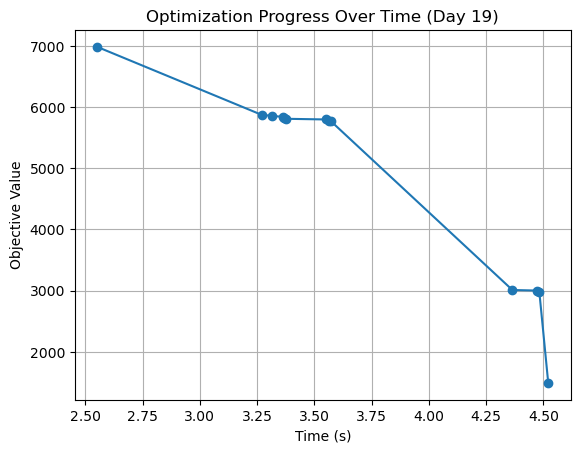

In [17]:
if __name__ == "__main__":
    # Get the logs
    logs = solve_hospital_allocation()

    # Best objective
    days = [] # List for day numbers
    penalties = [] # List for best objective value

    # Go through the logs of each day
    for day, data in logs.items():
        if data["objectives"]:  # Check for improving solutions
            days.append(day) # Add the number of the day
            penalties.append(data["objectives"][-1])  # Best found objective value


    # Plot total cost for loged solutions accross time for a specific day
    import matplotlib.pyplot as plt 
    day_to_plot = 19 # Specific day to plot
    if day_to_plot in logs and logs[day_to_plot]["objectives"]:
        day_data = logs[day_to_plot] # Data for that day
        plt.plot(day_data["times"], day_data["objectives"], marker='o') # Line plot with markers
        plt.xlabel("Time (s)") 
        plt.ylabel("Objective Value") 
        plt.title(f"Optimization Progress Over Time (Day {day_to_plot})") # Title 
        plt.savefig("feasible19.png", dpi=300) # Save the plot
        plt.grid(True) 
        plt.show() # Display 